[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-reducers.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239428-lesson-2-state-reducers)

# State Reducers 

## Review

これまでLangGraphのステートスキーマを定義する方法として、`TypedDict`、`Pydantic`、`Dataclasses`などを取り上げました。

## Goals

ここからは、ステートスキーマの特定のキー/チャンネルに対してどのように状態更新を行うかを指定する `reducers` について説明します。


In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

## Default overwriting state

ステートスキーマとして`TypedDict`を使ってみましょう。


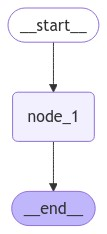

In [1]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing import Any


class State(TypedDict):
    foo: int


def node_1(state) -> dict[str, Any]:
    print("---Node 1---")
    return {"foo": state["foo"] + 1}


# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [2]:
graph.invoke({"foo": 1})

---Node 1---


{'foo': 2}

状態を更新する `return {"foo": state['foo'] + 1}` を見てみましょう。

前に説明したように、デフォルトではLangGraphは状態を更新するのに適した方法ではありません。

つまり、`node_1` の `foo` の値を上書きするだけです：

``
return {"foo": state['foo'] + 1}
``

入力として `{'foo': 1}` を渡すと、グラフから返される状態は `{'foo': 2}` になります。

## 分岐(Branching)

ノードが分岐する場合を見てみましょう。



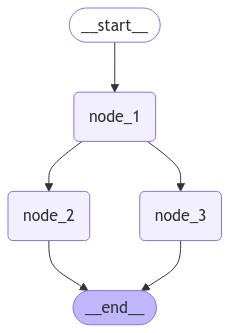

In [3]:
class State(TypedDict):
    foo: int


def node_1(state) -> dict[str, Any]:
    print("---Node 1---")
    return {"foo": state["foo"] + 1}


def node_2(state) -> dict[str, Any]:
    print("---Node 2---")
    return {"foo": state["foo"] + 1}


def node_3(state) -> dict[str, Any]:
    print("---Node 3---")
    return {"foo": state["foo"] + 1}


# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
from langgraph.errors import InvalidUpdateError

try:
    graph.invoke({"foo": 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")


---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.


問題があります！

ノード1はノード2と3に分岐します。

ノード2と3は並列に実行され、グラフの同じステップで実行されます。

両者は *同じステップ内* で状態を上書きしようとします。

これはグラフにとって曖昧です！どちらの状態を保持すべきでしょうか？


## Reducers

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)はこの問題に対処する一般的な方法を与えてくれます。

Reducersはどのように更新を行うかを指定します。

`Annotated` 型を使ってreducer関数を指定することができます。

例えば、この場合、各ノードから返された値を上書きするのではなく、追加します。

これを実行できるreducerが必要です： `operator.add` は Python の組み込み演算子モジュールの関数です。

`operator.add`はPythonの組み込み演算子モジュールの関数で、リストに適用するとリストの連結を行います。


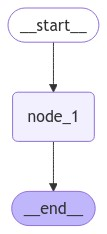

In [13]:
from operator import add
from typing import Annotated


class State(TypedDict):
    foo: Annotated[list[int], add]


def node_1(state: State) -> dict[str, list]:
    print("---Node 1---")
    return {"foo": [state["foo"][0] + 1]}


# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
graph.invoke({"foo": [4]})

---Node 1---


{'foo': [4, 5]}

ここで、ステートキー `foo` はリストです。

この `operator.add` reducer関数は、各ノードの更新をこのリストに追加します。

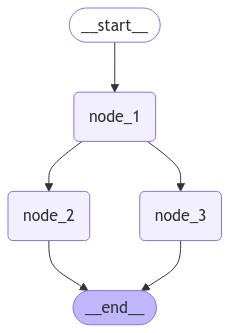

In [17]:
def node_1(state: State) -> dict[str, list]:
    print("---Node 1---")
    return {"foo": [state["foo"][-1] + 1]}


def node_2(state: State) -> dict[str, list]:
    print("---Node 2---")
    return {"foo": [state["foo"][-1] + 2]}


def node_3(state: State) -> dict[str, list]:
    print("---Node 3---")
    return {"foo": [state["foo"][-1] + 3]}


# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

ノード2とノード3の更新は同じステップにあるため、同時に実行されていることがわかります。

In [18]:
# 1, ←最初に渡した1
# 2, ←node1での演算 + 1
# 4, ←node1の結果(2)に、node2での演算である + 2
# 5, ←node1の結果(2)に、node3での演算である + 3
graph.invoke({"foo": [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 4, 5]}

では、`foo` に `None` を渡すとどうなるか見てみましょう。

`operator.add` は `NoneType` を入力として `node_1` の list に連結しようとするので、エラーが発生します。


In [20]:
try:
    graph.invoke({"foo": None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


## Custom Reducers

このようなケースに対応するために、[カスタムリデューサー(custom reducer)を定義することもできます](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state)。

例えば、カスタムリデューサロジックを定義して、リストを結合したり、入力のどちらか、あるいは両方が `None` であるようなケースを処理したりすることができます。


In [23]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right


class DefaultState(TypedDict):
    foo: Annotated[list[int], add]


class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

`node_1`に値2を追加します。

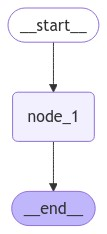

TypeError occurred: can only concatenate list (not "NoneType") to list


In [24]:
def node_1(state) -> dict[str, list[int]]:
    print("---Node 1---")
    return {"foo": [2]}


# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo": None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

では、カスタムreducerで試してみましょう。エラーが投げられないことがわかります。

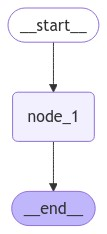

---Node 1---
{'foo': [2]}


In [26]:
# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo": None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## Messages

モジュール1 では、組み込みのレデューサである `add_messages` を使ってステート内のメッセージを処理する方法を紹介しました。

また、[`MessagesState` はメッセージを扱う際に便利なショートカットである](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate) ということも紹介しました。

* `MessagesState` は組み込みの `messages` キーを持っています
* また、このキーに対して組み込みの `add_messages` リデューサも持っています

この2つは等価です。

ここでは、簡潔にするために `from langgraph.graph import MessagesState` 経由で `MessagesState` クラスを使うことにします。




In [27]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


# add_messages reducerでメッセージのリストを含むカスタムTypedDictを定義します。
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc


# add_messages reducerでメッセージキーを含むMessagesStateを使用します。
class ExtendedMessagesState(MessagesState):
    # messages以外に必要なキーを追加します。
    added_key_1: str
    added_key_2: str
    # etc

`add_messages`レデューサーの使い方についてもう少し説明しましょう。

In [28]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model"),
    HumanMessage(content="I'm looking for information on marine biology.", name="Lance"),
]

# New message to add
new_message = AIMessage(
    content="Sure, I can help with that. What specifically are you interested in?",
    name="Model",
)

# Test
add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='97a6039d-8f67-4c6e-af58-eb8bb1e2d07c'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='42383562-7a4b-47d4-bab6-f79d91a82db1'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='40731683-c5cd-4c0a-9d2b-e07ec4a5b5fd')]

つまり、`add_messages` を使うとステート内の `messages` キーにメッセージを追加できることがわかります。

### Re-writing

`add_messages` リデューサーの便利なトリックを紹介しましょう。

messages` リストに既存のメッセージと同じ ID を持つメッセージを渡すと、そのメッセージは上書きされます！


In [33]:
from langchain_core.messages import SystemMessage

# Initial state
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2"),
]

# New message to add
new_message = SystemMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

# Test
add_messages(initial_messages, new_message)
# from langgraph.graph.message import add_messages は、メッセージの種類が違っても、idが同じなら上書きされる

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 SystemMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

### Removal

`add_messages`は[メッセージの削除も可能](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/)です。

これには `langchain_core` の [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) を使います。


In [36]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Isolate messages to delete
print([m.id for m in messages])
print([m.id for m in messages[:-2]])
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

['1', '2', '3', '4']
['1', '2']
[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [37]:
add_messages(messages, delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

`delete_messages`にあるように、mesage IDの1と2がreducerによって削除されていることがわかります。

これが実際に使われるのはもう少し後のことになります。
